# import

In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf 
import os
from skimage import color
from skimage import io
import skimage
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from sklearn.preprocessing import LabelBinarizer 
from skimage.transform import resize
from sklearn.model_selection import train_test_split
import random
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout
from keras.models import Model
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint 
from keras.utils import plot_model
from glob import glob
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, LeakyReLU, Dropout
from keras.models import Model
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint 
from keras.utils import plot_model


Using TensorFlow backend.


# Downloading the dataset

In [2]:
DATA_FOLDER = '/kaggle/input/animefacedataset'
WEIGHTS_FOLDER = './weights/'

In [3]:

# if not os.path.exists(WEIGHTS_FOLDER):
#   os.makedirs(os.path.join(WEIGHTS_FOLDER,"VAE"))

In [4]:
filenames = np.array(glob(os.path.join(DATA_FOLDER, '*/*')))
NUM_IMAGES = len(filenames)
print("Total number of images : " + str(NUM_IMAGES))

Total number of images : 63565


In [5]:
INPUT_DIM = (128,128,3) # Image dimension
BATCH_SIZE = 512
Z_DIM = 200 # Dimension of the latent vector (z)

data_flow = ImageDataGenerator(rescale=1./255).flow_from_directory(DATA_FOLDER, 
                                                                   target_size = INPUT_DIM[:2],
                                                                   batch_size = BATCH_SIZE,
                                                                   shuffle = True,
                                                                   class_mode = 'input',
                                                                   subset = 'training'
                                                                   )

Found 63565 images belonging to 1 classes.


# MODEL ARCHITECTURE

## Building the Encoder

In [6]:
#  ENCODER
def build_encoder(input_dim, output_dim, conv_filters, conv_kernel_size, 
                  conv_strides):
  
  # Clear tensorflow session to reset layer index numbers to 0 for LeakyRelu, 
  # BatchNormalization and Dropout.
  # Otherwise, the names of above mentioned layers in the model 
  # would be inconsistent
  global K
  K.clear_session()
  
  # Number of Conv layers
  n_layers = len(conv_filters)

  # Define model input
  encoder_input = Input(shape = input_dim, name = 'encoder_input')
  x = encoder_input

  # Add convolutional layers
  for i in range(n_layers):
      x = Conv2D(filters = conv_filters[i], 
                  kernel_size = conv_kernel_size[i],
                  strides = conv_strides[i], 
                  padding = 'same',
                  name = 'encoder_conv_' + str(i)
                  )(x)

      x = LeakyReLU()(x)
    
  # Required for reshaping latent vector while building Decoder
  shape_before_flattening = K.int_shape(x)[1:] 
  
  x = Flatten()(x)

  # Define model output
  encoder_output = Dense(output_dim, name = 'encoder_output')(x)

  return encoder_input, encoder_output, shape_before_flattening, Model(encoder_input, encoder_output)


In [7]:
encoder_input, encoder_output,  shape_before_flattening, encoder  = build_encoder(input_dim = INPUT_DIM,
                                    output_dim = Z_DIM, 
                                    conv_filters = [32, 64, 64, 64],
                                    conv_kernel_size = [3,3,3,3],
                                    conv_strides = [2,2,2,2])

encoder.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 128, 128, 3)       0         
_________________________________________________________________
encoder_conv_0 (Conv2D)      (None, 64, 64, 32)        896       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 32)        0         
_________________________________________________________________
encoder_conv_1 (Conv2D)      (None, 32, 32, 64)        18496     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
encoder_conv_2 (Conv2D)      (None, 16, 16, 64)        36928     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 64)        0   

## Building the Decoder


In [8]:
# Decoder
def build_decoder(input_dim, shape_before_flattening, conv_filters, conv_kernel_size, 
                  conv_strides):

  # Number of Conv layers
  n_layers = len(conv_filters)

  # Define model input
  decoder_input = Input(shape = (input_dim,) , name = 'decoder_input')

  # To get an exact mirror image of the encoder
  x = Dense(np.prod(shape_before_flattening))(decoder_input)
  x = Reshape(shape_before_flattening)(x)

  # Add convolutional layers
  for i in range(n_layers):
      x = Conv2DTranspose(filters = conv_filters[i], 
                  kernel_size = conv_kernel_size[i],
                  strides = conv_strides[i], 
                  padding = 'same',
                  name = 'decoder_conv_' + str(i)
                  )(x)
      
      # Adding a sigmoid layer at the end to restrict the outputs 
      # between 0 and 1
      if i < n_layers - 1:
        x = LeakyReLU()(x)
      else:
        x = Activation('sigmoid')(x)

  # Define model output
  decoder_output = x

  return decoder_input, decoder_output, Model(decoder_input, decoder_output)

In [9]:
decoder_input, decoder_output, decoder = build_decoder(input_dim = Z_DIM,
                                        shape_before_flattening = shape_before_flattening,
                                        conv_filters = [64,64,32,3],
                                        conv_kernel_size = [3,3,3,3],
                                        conv_strides = [2,2,2,2]
                                        )
decoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              823296    
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 64)          0         
_________________________________________________________________
decoder_conv_0 (Conv2DTransp (None, 16, 16, 64)        36928     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
decoder_conv_1 (Conv2DTransp (None, 32, 32, 64)        36928     
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 32, 32, 64)        0   

## Attaching the Decoder to the Encoder

In [10]:
# The input to the model will be the image fed to the encoder.
simple_autoencoder_input = encoder_input

# The output will be the output of the decoder. The term - decoder(encoder_output) 
# combines the model by passing the encoder output to the input of the decoder.
simple_autoencoder_output = decoder(encoder_output)

# Input to the combined model will be the input to the encoder.
# Output of the combined model will be the output of the decoder.
simple_autoencoder = Model(simple_autoencoder_input, simple_autoencoder_output)

simple_autoencoder.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 128, 128, 3)       0         
_________________________________________________________________
encoder_conv_0 (Conv2D)      (None, 64, 64, 32)        896       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 64, 64, 32)        0         
_________________________________________________________________
encoder_conv_1 (Conv2D)      (None, 32, 32, 64)        18496     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 32, 32, 64)        0         
_________________________________________________________________
encoder_conv_2 (Conv2D)      (None, 16, 16, 64)        36928     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 64)        0   

In [11]:
LEARNING_RATE = 0.0005
N_EPOCHS = 10

optimizer = Adam(lr = LEARNING_RATE)

def r_loss(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred), axis = [1,2,3])

# simple_autoencoder.compile(optimizer=optimizer, loss = r_loss)

# checkpoint_ae = ModelCheckpoint(os.path.join(WEIGHTS_FOLDER, 'AE/weights.h5'), save_weights_only = True, verbose=1)

# VARIATIONAL AUTOENCODER

##Building the Encoder

In [12]:
# ENCODER
def build_vae_encoder(input_dim, output_dim, conv_filters, conv_kernel_size, 
                  conv_strides, use_batch_norm = False, use_dropout = False):
  
  # Clear tensorflow session to reset layer index numbers to 0 for LeakyRelu, 
  # BatchNormalization and Dropout.
  # Otherwise, the names of above mentioned layers in the model 
  # would be inconsistent
  global K
  K.clear_session()
  
  # Number of Conv layers
  n_layers = len(conv_filters)

  # Define model input
  encoder_input = Input(shape = input_dim, name = 'encoder_input')
  x = encoder_input

  # Add convolutional layers
  for i in range(n_layers):
      x = Conv2D(filters = conv_filters[i], 
                  kernel_size = conv_kernel_size[i],
                  strides = conv_strides[i], 
                  padding = 'same',
                  name = 'encoder_conv_' + str(i)
                  )(x)
      if use_batch_norm:
        x = BathcNormalization()(x)
  
      x = LeakyReLU()(x)

      if use_dropout:
        x = Dropout(rate=0.25)(x)

  # Required for reshaping latent vector while building Decoder
  shape_before_flattening = K.int_shape(x)[1:] 
  
  x = Flatten()(x)
  
  mean_mu = Dense(output_dim, name = 'mu')(x)
  log_var = Dense(output_dim, name = 'log_var')(x)

  # Defining a function for sampling
  def sampling(args):
    mean_mu, log_var = args
    epsilon = K.random_normal(shape=K.shape(mean_mu), mean=0., stddev=1.) 
    return mean_mu + K.exp(log_var/2)*epsilon   
  
  # Using a Keras Lambda Layer to include the sampling function as a layer 
  # in the model
  encoder_output = Lambda(sampling, name='encoder_output')([mean_mu, log_var])

  return encoder_input, encoder_output, mean_mu, log_var, shape_before_flattening, Model(encoder_input, encoder_output)

In [13]:
vae_encoder_input, vae_encoder_output,  mean_mu, log_var, vae_shape_before_flattening, vae_encoder  = build_vae_encoder(input_dim = INPUT_DIM,
                                    output_dim = Z_DIM, 
                                    conv_filters = [32, 64, 64, 64],
                                    conv_kernel_size = [3,3,3,3],
                                    conv_strides = [2,2,2,2])

vae_encoder.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
encoder_conv_0 (Conv2D)         (None, 64, 64, 32)   896         encoder_input[0][0]              
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 64, 64, 32)   0           encoder_conv_0[0][0]             
__________________________________________________________________________________________________
encoder_conv_1 (Conv2D)         (None, 32, 32, 64)   18496       leaky_re_lu_1[0][0]              
____________________________________________________________________________________________

##Building the Decoder

In [14]:

vae_decoder_input, vae_decoder_output, vae_decoder = build_decoder(input_dim = Z_DIM,
                                        shape_before_flattening = shape_before_flattening,
                                        conv_filters = [64,64,32,3],
                                        conv_kernel_size = [3,3,3,3],
                                        conv_strides = [2,2,2,2]
                                        )
vae_decoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              823296    
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 64)          0         
_________________________________________________________________
decoder_conv_0 (Conv2DTransp (None, 16, 16, 64)        36928     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
decoder_conv_1 (Conv2DTransp (None, 32, 32, 64)        36928     
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 32, 32, 64)        0   

## Attaching the Decoder to the Encoder

In [15]:

# The input to the model will be the image fed to the encoder.
vae_input = vae_encoder_input

# Output will be the output of the decoder. The term - decoder(encoder_output) 
# combines the model by passing the encoder output to the input of the decoder.
vae_output = vae_decoder(vae_encoder_output)

# Input to the combined model will be the input to the encoder.
# Output of the combined model will be the output of the decoder.
vae_model = Model(vae_input, vae_output)

vae_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
encoder_conv_0 (Conv2D)         (None, 64, 64, 32)   896         encoder_input[0][0]              
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 64, 64, 32)   0           encoder_conv_0[0][0]             
__________________________________________________________________________________________________
encoder_conv_1 (Conv2D)         (None, 32, 32, 64)   18496       leaky_re_lu_1[0][0]              
____________________________________________________________________________________________

## COMPILATION AND TRAINING

In [16]:
LEARNING_RATE = 0.0005
N_EPOCHS = 200
LOSS_FACTOR = 10000

In [17]:

def kl_loss(y_true, y_pred):
    kl_loss =  -0.5 * K.sum(1 + log_var - K.square(mean_mu) - K.exp(log_var), axis = 1)
    return kl_loss

def total_loss(y_true, y_pred):
    return LOSS_FACTOR*r_loss(y_true, y_pred) + kl_loss(y_true, y_pred)

In [18]:
adam_optimizer = Adam(lr = LEARNING_RATE)

vae_model.compile(optimizer=adam_optimizer, loss = total_loss, metrics = [r_loss, kl_loss])


In [19]:

vae_model.fit_generator(data_flow, 
                        shuffle=True, 
                        epochs = 50, 
                        initial_epoch = 0, 
                        steps_per_epoch=NUM_IMAGES / BATCH_SIZE)#,
                        #callbacks=[checkpoint_vae])

Epoch 1/50
125/124 [==============================] - 601s 5s/step - loss: 638.8433 - r_loss: 0.0617 - kl_loss: 19.5978
Epoch 2/50
125/124 [==============================] - 593s 5s/step - loss: 441.0579 - r_loss: 0.0401 - kl_loss: 40.4734
Epoch 3/50
125/124 [==============================] - 596s 5s/step - loss: 385.4769 - r_loss: 0.0338 - kl_loss: 47.9560
Epoch 4/50
125/124 [==============================] - 607s 5s/step - loss: 353.9836 - r_loss: 0.0304 - kl_loss: 50.0122
Epoch 5/50
125/124 [==============================] - 610s 5s/step - loss: 341.2017 - r_loss: 0.0290 - kl_loss: 51.6005
Epoch 6/50
125/124 [==============================] - 607s 5s/step - loss: 334.0377 - r_loss: 0.0281 - kl_loss: 53.0714
Epoch 7/50
125/124 [==============================] - 605s 5s/step - loss: 328.6979 - r_loss: 0.0275 - kl_loss: 54.1626
Epoch 8/50
125/124 [==============================] - 607s 5s/step - loss: 325.8152 - r_loss: 0.0271 - kl_loss: 55.1991
Epoch 9/50
125/124 [====================

##RECONSTRUCTION

In [20]:

example_batch = next(data_flow)
example_batch = example_batch[0]
example_images = example_batch[:10]

In [21]:
def plot_compare_vae(images=None):
  
  if images is None:
    example_batch = next(data_flow)
    example_batch = example_batch[0]
    images = example_batch[:10]

  n_to_show = images.shape[0]
  reconst_images = vae_model.predict(images)

  fig = plt.figure(figsize=(15, 3))
  fig.subplots_adjust(hspace=0.4, wspace=0.4)

  for i in range(n_to_show):
      img = images[i].squeeze()
      sub = fig.add_subplot(2, n_to_show, i+1)
      sub.axis('off')        
      sub.imshow(img)

  for i in range(n_to_show):
      img = reconst_images[i].squeeze()
      sub = fig.add_subplot(2, n_to_show, i+n_to_show+1)
      sub.axis('off')
      sub.imshow(img)

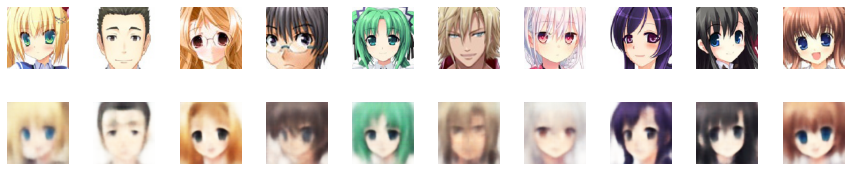

In [22]:
plot_compare_vae(images = example_images)

# Generating new faces from random vectors sampled from a standard normal distribution.

In [23]:
def vae_generate_images(n_to_show=10):
  reconst_images = vae_decoder.predict(np.random.normal(0,1,size=(n_to_show,Z_DIM)))

  fig = plt.figure(figsize=(15, 3))
  fig.subplots_adjust(hspace=0.4, wspace=0.4)

  for i in range(n_to_show):
        img = reconst_images[i].squeeze()
        sub = fig.add_subplot(2, n_to_show, i+1)
        sub.axis('off')        
        sub.imshow(img)

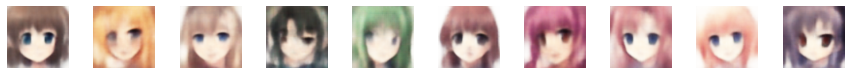

In [24]:
vae_generate_images(n_to_show=10)

In [25]:
from scipy.stats import norm

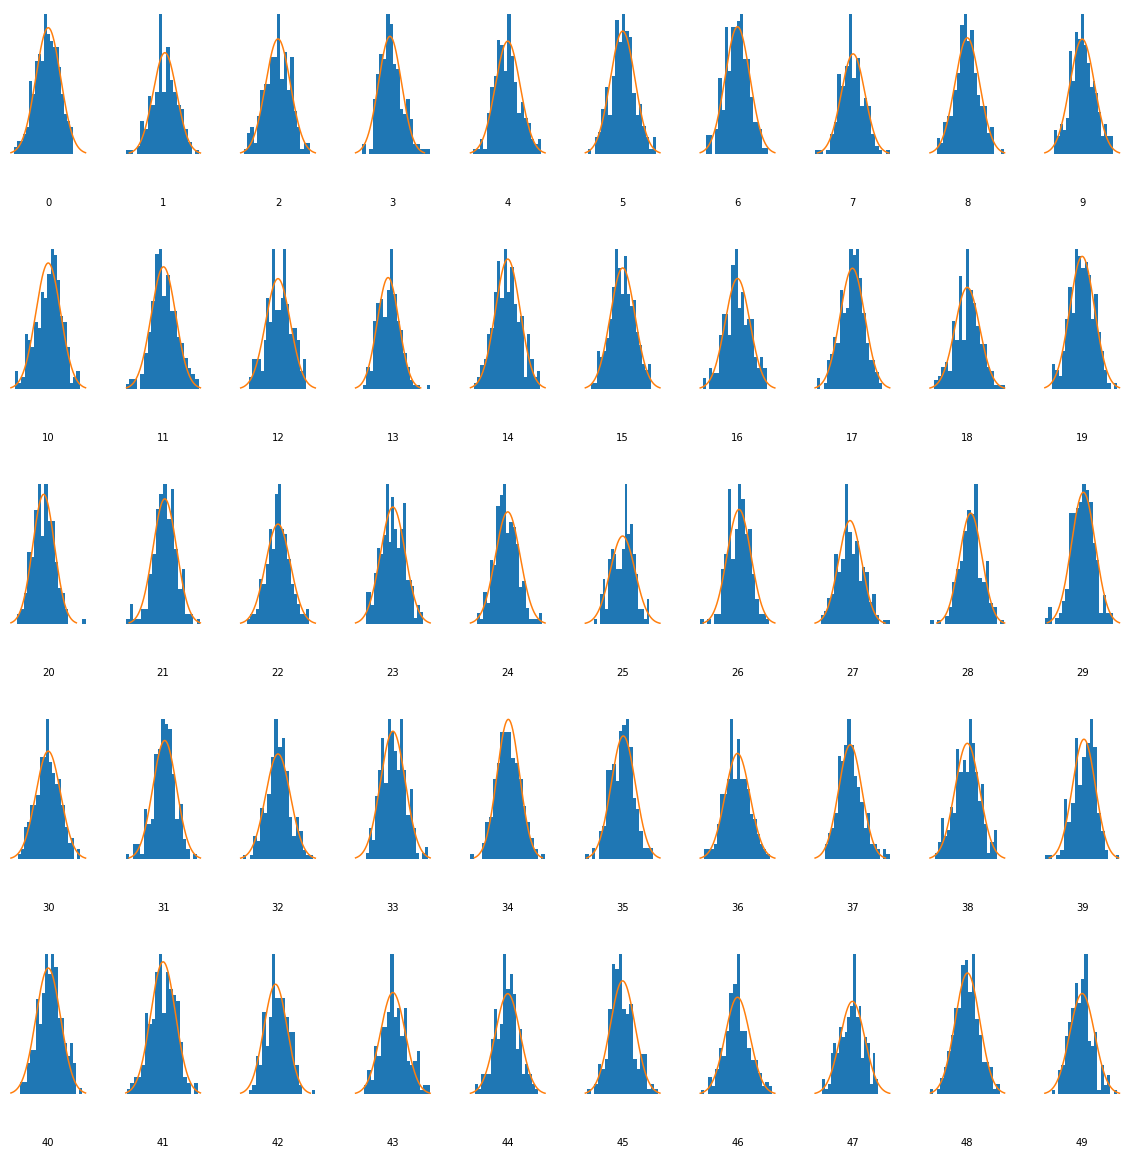

In [26]:

z_test = vae_encoder.predict(example_batch[:200])

x = np.linspace(-3, 3, 300)

fig = plt.figure(figsize=(20, 20))
fig.subplots_adjust(hspace=0.6, wspace=0.4)

for i in range(50):
    ax = fig.add_subplot(5, 10, i+1)
    ax.hist(z_test[:,i], density=True, bins = 20)
    ax.axis('off')
    ax.text(0.5, -0.35, str(i), fontsize=10, ha='center', transform=ax.transAxes)
    ax.plot(x,norm.pdf(x))

plt.show()